# Test Performance of experiments on test dataset

In [2]:
import os
import pickle
import json
from random import sample
from tqdm.auto import tqdm
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score
)

from sesm import get_data
from trainer import PLModel

/home/brenton/.conda/envs/EEG-SESM/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


OSError: /home/brenton/.conda/envs/EEG-SESM/lib/python3.10/site-packages/torch/lib/../../../../libcublas.so.11: symbol cublasLtGetStatusString version libcublasLt.so.11 not defined in file libcublasLt.so.11 with link time reference

## Load data and model

In [4]:
CLASS_DICT = {
    0: "W",
    1: "N1",
    2: "N2",
    3: "N3",
    4: "REM"
}

In [5]:
config = json.load(open("configs/sleep_edf.json", "r"))

In [6]:
train_loader, val_loader, test_loader, class_weights, max_len = get_data(
    config["dataset"], 4
)
config.update({"class_weights": class_weights, "max_len": max_len})

Load training set:
Loading datasets/eeg/sleep_edf/prepared/fpz_cz/SC4031E0.npz ...
Loading datasets/eeg/sleep_edf/prepared/fpz_cz/SC4032E0.npz ...
Loading datasets/eeg/sleep_edf/prepared/fpz_cz/SC4041E0.npz ...
Loading datasets/eeg/sleep_edf/prepared/fpz_cz/SC4042E0.npz ...
Loading datasets/eeg/sleep_edf/prepared/fpz_cz/SC4051E0.npz ...
Loading datasets/eeg/sleep_edf/prepared/fpz_cz/SC4052E0.npz ...
Loading datasets/eeg/sleep_edf/prepared/fpz_cz/SC4061E0.npz ...
Loading datasets/eeg/sleep_edf/prepared/fpz_cz/SC4062E0.npz ...
Loading datasets/eeg/sleep_edf/prepared/fpz_cz/SC4071E0.npz ...
Loading datasets/eeg/sleep_edf/prepared/fpz_cz/SC4072E0.npz ...
Loading datasets/eeg/sleep_edf/prepared/fpz_cz/SC4081E0.npz ...
Loading datasets/eeg/sleep_edf/prepared/fpz_cz/SC4082E0.npz ...
Loading datasets/eeg/sleep_edf/prepared/fpz_cz/SC4091E0.npz ...
Loading datasets/eeg/sleep_edf/prepared/fpz_cz/SC4092E0.npz ...
Loading datasets/eeg/sleep_edf/prepared/fpz_cz/SC4101E0.npz ...
Loading datasets/eeg/

In [7]:
# Set up experiment 1 config
config_1 = config.copy()
config_1["d_embed"] = 16
config_1["d_hidden"] = 16
config_1["d_kernel"] = 10

# Set up experiment 2 config
config_2 = config.copy()
config_2["d_kernel"] = 10

In [8]:
plmodel_exp1 = PLModel(stage=2, **config_1)
plmodel_exp1.model.load_state_dict(torch.load("models/trained_model_exp1.pt"))

plmodel_exp2 = PLModel(stage=2, **config_2)
plmodel_exp2.model.load_state_dict(torch.load("models/trained_model_exp2.pt"))

plmodel_exp3 = PLModel(stage=2, **config)
plmodel_exp3.model.load_state_dict(torch.load("models/trained_model_exp3.pt"))

<All keys matched successfully>

In [9]:
model_exp1 = plmodel_exp1.model
model_exp2 = plmodel_exp2.model
model_exp3 = plmodel_exp3.model

model_exp1.eval()
model_exp2.eval()
model_exp3.eval()

Model(
  (embedder): Embedder(
    (embed): Sequential(
      (0): Conv1d(1, 64, kernel_size=(50,), stride=(1,), padding=same)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Swish()
    )
  )
  (conceptizer): Conceptizer(
    (multi_head_selective_attention): MultiHeadSelectiveAttention(
      (w_q): Linear(in_features=64, out_features=64, bias=True)
      (w_k): Linear(in_features=64, out_features=64, bias=True)
      (w_v): Linear(in_features=64, out_features=8, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (gumbel): GumbelSigmoid()
    )
    (encoder): Sequential(
      (0): ConvNormPool(
        (conv_1): Conv1d(64, 64, kernel_size=(50,), stride=(1,))
        (conv_2): Conv1d(64, 64, kernel_size=(50,), stride=(1,))
        (conv_3): Conv1d(64, 64, kernel_size=(50,), stride=(1,))
        (swish_1): Swish()
        (swish_2): Swish()
        (swish_3): Swish()
        (normalization_1): BatchNorm1d(64, eps=1e-05

## Calculate accuracy on test dataset

In [10]:
def test_model(model, output_location, model_name):

    os.makedirs(output_location, exist_ok=True)
    os.makedirs(os.path.join(output_location, model_name), exist_ok=True)

    x_orig = []
    y_pred = []
    y_true = []
    selective_actions_list = []
    relevance_weights_list = []
    predicted_head = []

    for x, y in tqdm(test_loader):
        x, y = x, y
        batch_size = x.shape[0]
        y_hat_, _, selective_actions, relevance_weights = model(x, x != 0, ignore_relevance_weights=True) 
        
        y_hat_ = y_hat_.detach().reshape(batch_size, config['n_heads'], -1).cpu()
        selective_actions = selective_actions.detach().cpu()
        relevance_weights = relevance_weights.detach().cpu() 
        x = x.detach().cpu()
        y = y.detach().cpu()

        y_hat = (y_hat_ * relevance_weights.unsqueeze(-1)).sum(1)

        x_orig.append(np.concatenate(x.numpy()))
        y_pred.append(y_hat.argmax(1).numpy())
        y_true.append(y.numpy())
        selective_actions_list.append(selective_actions.numpy())
        relevance_weights_list.append(relevance_weights.numpy())
        predicted_head.append(F.softmax(y_hat_, -1).numpy())
        del x, y, y_hat, _, selective_actions, relevance_weights
        
    x_orig = np.concatenate(x_orig)
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    selective_actions = np.concatenate(selective_actions_list)
    relevance_weights = np.concatenate(relevance_weights_list)
    predicted_head = np.concatenate(predicted_head)

    with open(f'{output_location}/{model_name}/x_orig_test.pkl','wb') as f:
        pickle.dump(x_orig, f, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'{output_location}/{model_name}/y_true_test.pkl','wb') as f:
        pickle.dump(y_true, f, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'{output_location}/{model_name}/y_pred_test.pkl','wb') as f:
        pickle.dump(y_pred, f, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'{output_location}/{model_name}/selective_actions_test.pkl','wb') as f:
        pickle.dump(selective_actions, f, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'{output_location}/{model_name}/relevance_weights_test.pkl','wb') as f:
        pickle.dump(relevance_weights, f, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'{output_location}/{model_name}/predicted_head_test.pkl','wb') as f:
        pickle.dump(predicted_head, f, protocol=pickle.HIGHEST_PROTOCOL)

    del x_orig
    del y_true
    del y_pred
    del selective_actions
    del relevance_weights
    del predicted_head
    
    return os.path.join(output_location, model_name)

In [11]:
prediction_locations = [ test_model(model[0], 'test_outputs', model[1]) for model in [(model_exp1, 'exp1'), (model_exp2, 'exp2'), (model_exp3, 'exp3')] ]

  0%|          | 0/509 [00:00<?, ?it/s]

/home/brenton/.conda/envs/EEG-SESM/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484803030/work/aten/src/ATen/native/Convolution.cpp:882.)
  return F.conv1d(input, weight, bias, self.stride,


  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

Results from Experiment 0
-------------------------------
Accuracy: 0.5619469026548672
Precision: 0.7309526978598002
Recall: 0.5333455682318796


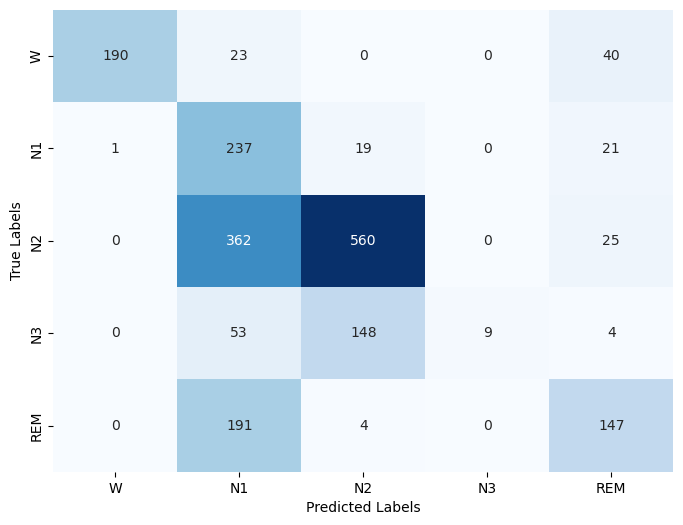

Classification Report:
              precision    recall  f1-score   support

           W       0.99      0.75      0.86       253
          N1       0.27      0.85      0.41       278
          N2       0.77      0.59      0.67       947
          N3       1.00      0.04      0.08       214
         REM       0.62      0.43      0.51       342

    accuracy                           0.56      2034
   macro avg       0.73      0.53      0.51      2034
weighted avg       0.73      0.56      0.57      2034



Accuracy for W: 75.10%
Accuracy for N1: 85.25%
Accuracy for N2: 59.13%
Accuracy for N3: 4.21%
Accuracy for REM: 42.98%



Results from Experiment 1
-------------------------------
Accuracy: 0.7728613569321534
Precision: 0.7274687885935504
Recall: 0.7870835862335197


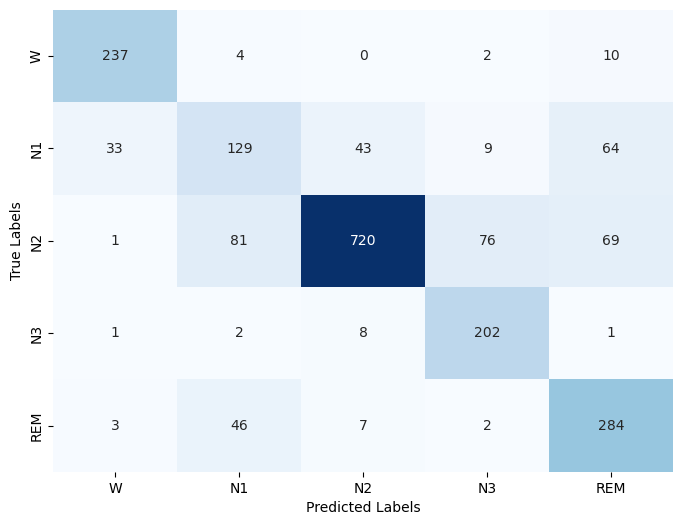

Classification Report:
              precision    recall  f1-score   support

           W       0.86      0.94      0.90       253
          N1       0.49      0.46      0.48       278
          N2       0.93      0.76      0.83       947
          N3       0.69      0.94      0.80       214
         REM       0.66      0.83      0.74       342

    accuracy                           0.77      2034
   macro avg       0.73      0.79      0.75      2034
weighted avg       0.79      0.77      0.77      2034



Accuracy for W: 93.68%
Accuracy for N1: 46.40%
Accuracy for N2: 76.03%
Accuracy for N3: 94.39%
Accuracy for REM: 83.04%



Results from Experiment 2
-------------------------------
Accuracy: 0.7935103244837758
Precision: 0.7788520620025153
Recall: 0.7968389301671902


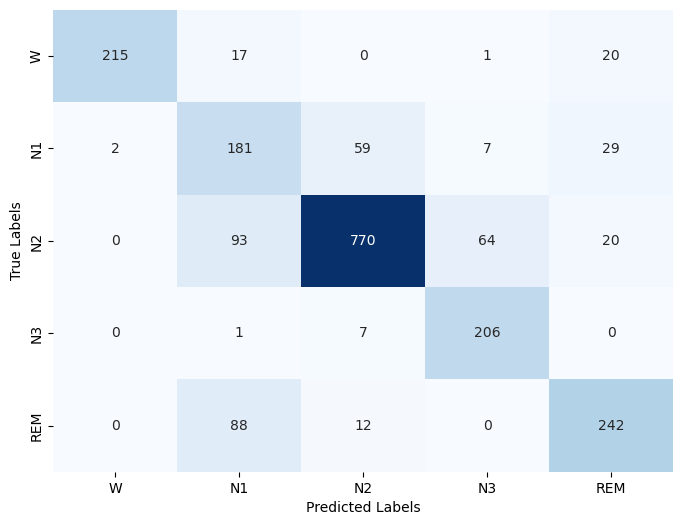

Classification Report:
              precision    recall  f1-score   support

           W       0.99      0.85      0.91       253
          N1       0.48      0.65      0.55       278
          N2       0.91      0.81      0.86       947
          N3       0.74      0.96      0.84       214
         REM       0.78      0.71      0.74       342

    accuracy                           0.79      2034
   macro avg       0.78      0.80      0.78      2034
weighted avg       0.82      0.79      0.80      2034



Accuracy for W: 84.98%
Accuracy for N1: 65.11%
Accuracy for N2: 81.31%
Accuracy for N3: 96.26%
Accuracy for REM: 70.76%





In [13]:
class_names = CLASS_DICT.values()

for i, location in enumerate(prediction_locations):

    with open(f'{location}/x_orig_test.pkl','rb') as f:
        x_orig = pickle.load(f)

    with open(f'{location}/y_true_test.pkl','rb') as f:
        y_true = pickle.load(f)

    with open(f'{location}/y_pred_test.pkl','rb') as f:
        y_pred = pickle.load(f)

    with open(f'{location}/selective_actions_test.pkl','rb') as f:
        selective_actions = pickle.load(f)

    with open(f'{location}/relevance_weights_test.pkl','rb') as f:
        relevance_weights = pickle.load(f)

    with open(f'{location}/predicted_head_test.pkl','rb') as f:
        predicted_head = pickle.load(f)

    print(f"Results from Experiment {i}")
    print(f"-------------------------------")
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

    # Create a confusion matrix
    confusion = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.gca().set_xticklabels(class_names)
    plt.ylabel('True Labels')
    plt.gca().set_yticklabels(class_names)
    plt.show()

    # Generate a classification report
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:")
    print(report)

    # Calculate class-wise accuracy
    class_accuracy = confusion.diagonal()/confusion.sum(axis=1)

    print("\n")
    # Print class-wise accuracy
    for i, class_name in enumerate(class_names):
        print(f'Accuracy for {class_name}: {class_accuracy[i]*100:.2f}%')

    print("\n\n")

    del x_orig
    del y_true
    del y_pred
    del selective_actions
    del relevance_weights
    del predicted_head